In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
%matplotlib inline

The amount of information is going to be less as the position in the hierarchy increases. And the amount of trust could be random throughout the network.

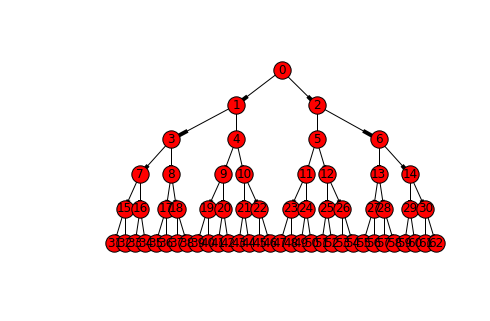

In [2]:
num_levels = 6
num_subordinates = 2
G = nx.DiGraph()
G.add_node(0)

leaf_nodes_last_level = [0]
nodes_in_levels = defaultdict(list)
nodes_in_levels[0] = [0]
levels_of_nodes = dict()
levels_of_nodes[0] = 0

for i in range(1, num_levels):
    #print i, pow(2,i)
    num_nodes_this_level = pow(2,i)
    possible_subordinates = range(G.number_of_nodes(), G.number_of_nodes()+ num_nodes_this_level )
    leaf_nodes_next_level = list(possible_subordinates)
    #print "possible subordinates", possible_subordinates

    while len(leaf_nodes_last_level) > 0:
        current_supervisor = leaf_nodes_last_level.pop(0)
        #print "after popping", leaf_nodes_last_level
        #print "##current supervisor", current_supervisor
        for j in range(num_subordinates):
            current_subordinate = possible_subordinates.pop(0)
            #print "####current subordinate", current_subordinate
            G.add_edge(current_supervisor, current_subordinate)
            #print "i", i
            nodes_in_levels[i].append(current_subordinate)
            levels_of_nodes[current_subordinate] = i
    leaf_nodes_last_level = list(leaf_nodes_next_level)
        
# pos = hierarchy_pos(btree2, 0)
#nx.draw(btree2,pos=nx.draw_networkx(btree2),with_labels=True,arrows=True)
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw(G,pos,with_labels=True,arrows=True)

Our first assumption is that the deeper the level the less the initial information $H$ in the node. And we will distribute the initial $\alpha$ value distributed randomly using a lognormal distributions with parameter $\mu$ and $\sigma$

In [3]:
def sample_h(level, mean_info = 0.7, sd_info = 0.05, dmu = 0.1, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        mu = mean_info - (dmu * (level-1))
        sigma = sd_info
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mean_info

def sample_alpha(mu = 0.5, sigma = 0.1, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mu

def sample_change_in_alpha(mu = 0.1, sigma = 0.01, constant = False):
    if constant == False:
        ## the distribution will be Truncated between 0 and 1
        lower, upper = 0, 1
        ## The distribution
        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        s = X.rvs(1)[0]
        return s
    else:
        return mu

We do not have any problem assigning H in node 0 as there is no edge pointing towards him. So for mu, dmu * (level -1 ) is not a problem.

In [4]:
def trust_flow(iteration_count, orders, mean_alpha  = 0.5, mean_info_higehst_level = 0.2, delta = 0, plot_network = False):
    
    sd_trust = 0.1
    dmu_each_level = mean_info_higehst_level / (num_levels - 1)
    mean_change_in_alpha = 0.05
    mean_change_in_delta = mean_change_in_alpha / 3
    sd_change_in_alpha = 0.001
    sd_change_in_delta = 0.0005

    for edge in G.edges():
        subordinate_node = edge[1]
        current_h = mean_info_higehst_level#sample_h(levels_of_nodes[subordinate_node], mean_info = mean_info_higehst_level, dmu = dmu_each_level)
        current_alpha = mean_alpha#sample_alpha(mean_trust, sd_trust)
        G[edge[0]][edge[1]]['H'] = current_h
        G[edge[0]][edge[1]]['alpha'] = current_alpha
    
    
    all_iterations = dict()
    for it in range(iteration_count):
        ## Order can be -1 or 1
        flips = {1:-1, -1:1}
        order = orders[it]
        print "iteration", it
        print order
        root_node = 0
        bits = dict()
        bits[root_node] = order
        flip_keep = dict()

        for edge in list(nx.bfs_edges(G ,root_node)):
            source_node = edge[0]
            target_node = edge[1]
            source_bit = bits[source_node]
            #print "##", edge, source_bit
            current_alpha = G[source_node][target_node]['alpha']
            current_info = G[source_node][target_node]['H']
            processed_info = current_alpha + current_info * source_bit
            #print "processed_info", processed_info, "delta", delta
            if processed_info >= delta:
                ## Keeping
                #print "Keeping"
                processed_bit = source_bit
                flip_keep[(source_node,target_node)] = 'keep'
            else:
                ## Flipping
                #print "Flipping"
                processed_bit = flips[source_bit]
                flip_keep[(source_node,target_node)] = 'flip'
            bits[target_node] = processed_bit

        ## We are counting the overall outcome in the whole system
        ## We need the good outcomes to be greater than bad outcomes to 
        ## make it a collective good outcome
        collective_outcome = ""

        ##  If its a good outcome:
        ##       if I followed my supervisors order, I trust him more
        ##       if I flipped my supervisors order, I trust him less
        ## If its a bad outcome:
        ##       if I followed my supervisors order, I trust him less
        ##       if I flipped my supervisors order, I trust him more 
        ##           (you can think of it this way, it is a bad outcome
        ##           and I did not abide by his order, and based on my local 
        ##           knowledge, I feel I should have gone with my supervisors
        ##           order)
        if Counter(bits.values())[1] > Counter(bits.values())[-1]:
            collective_outcome = "good"
            delta -= sample_change_in_alpha(mean_change_in_delta , sd_change_in_delta)
            if delta < 0:
                delta = 0
            print collective_outcome
            for edge, current_alpha in nx.get_edge_attributes(G, 'alpha').items():
                if flip_keep[edge] == "keep":
                ## It was a good outcome and I listened to my supervisor, so I feel he is a person I can trust more
                    #print edge, current_alpha
                    new_alpha = current_alpha + sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                    if new_alpha > 1:
                        new_alpha = 1
                    elif new_alpha < 0:
                        new_alpha = 0
                    G[edge[0]][edge[1]]['alpha'] = new_alpha
                else:
                ## It was a good outcome and I did not listen to my supervisor, so I feel he is a person I should trust less, because by not listening to him, I feel that I contributed to the good outcome
                    #print edge, current_alpha
                    new_alpha = current_alpha - sample_change_in_alpha(mean_change_in_alpha , sd_change_in_alpha)
                    if new_alpha > 1:
                        new_alpha = 1
                    elif new_alpha < 0:
                        new_alpha = 0
                    G[edge[0]][edge[1]]['alpha'] = new_alpha
        else:
            collective_outcome = "bad"
            delta += sample_change_in_alpha(mean_change_in_delta, sd_change_in_delta)
            if delta > 1:
                delta = 1
            print collective_outcome
            for edge, current_alpha in nx.get_edge_attributes(G, 'alpha').items():
                if flip_keep[edge] == "keep":
                ## It was a bad outcome and I listened to my supervisor, and by listening to him I contributed to the disaster, so I feel he is a person I should trust less
                    #print edge, current_alpha
                    new_alpha = current_alpha - sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                    if new_alpha > 1:
                        new_alpha = 1
                    elif new_alpha < 0:
                        new_alpha = 0
                    G[edge[0]][edge[1]]['alpha'] = new_alpha
                else:
                ## It was a bad outcome and I did not listen to my supervisor, so I feel by listening to him I could have averted the disaster, so I feel I should listen to him/ trust him more.
                    #print edge, current_alpha
                    new_alpha = current_alpha + sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
                    if new_alpha > 1:
                        new_alpha = 1
                    elif new_alpha < 0:
                        new_alpha = 0
                    G[edge[0]][edge[1]]['alpha'] = new_alpha

        all_iterations[it] = dict()
        all_iterations[it]['delta'] = delta
        all_iterations[it]['collective_outcome'] = collective_outcome
        #print collective_outcome
        all_iterations[it]['flip_keep'] = flip_keep
        #print Counter(flip_keep.values())
        all_iterations[it]['bits'] = bits
        #print Counter(bits.values())

        #print nx.get_edge_attributes(G, 'alpha')
        all_iterations[it]['alpha'] = nx.get_edge_attributes(G, 'alpha')

        labels = dict()
        alphas = nx.get_edge_attributes(G, 'alpha')
        Hs = nx.get_edge_attributes(G, 'H')
        for key in G.edges():
            #print key
            current_alpha = round(alphas[key], 1)
            current_H = round(Hs[key], 1)
            labels[key] = (current_alpha, current_H)
        # print labels
        if plot_network == True:
            plt.figure(figsize=(12,10))
            pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
            nx.draw_networkx_edge_labels(G,pos=nx.nx_pydot.graphviz_layout(G,prog='dot'), edge_labels = labels)
            color_map_node = {1:'g', -1:'r'} 
            color_map_edge = {"keep":'g', "flip":'r'} 
            # colors = [G[u][v]['color'] for u,v in edges]
            nx.draw(G,pos, node_color=[color_map_node[bits[node]] for node in G],  edge_color=[color_map_edge[flip_keep[edge]] for edge in G.edges()],with_labels=True,arrows=True)
            plt.title(str(it)+" "+str(order)+" "+str(collective_outcome))
    return all_iterations

In [5]:
def create_plots(iteration_count , alpha, delta, info, p_good_order, plot_network = False):
    mean_alpha = alpha
    iteration_count = iteration_count

    delta = delta ## The higher the delta the more skeptical we are
    mean_info_higehst_level = info

    p_good_order = p_good_order

    order_size = iteration_count
    binomial_list = np.random.binomial(1,p_good_order,size =order_size)

    plot_network = plot_network

    orders = list()
    for i in range(len(binomial_list)):
        if binomial_list[i] == 1:
            orders.append(1)
        else:
            orders.append(-1)



    all_iterations = trust_flow(iteration_count = iteration_count, orders = orders, mean_alpha = mean_alpha, mean_info_higehst_level = mean_info_higehst_level,delta = delta, plot_network = plot_network)
    
    list_mean_trust_keeps = list()
    list_mean_trust_flips = list()
    for i in range(len(all_iterations)):
        trust_in_keeps = np.array([], int)
        trust_in_flips = np.array([], int)
        #print all_iterations[i]
        for edge, value in all_iterations[i]['flip_keep'].items():
            if value == 'flip':
                #print edge, value
                trust_in_flips = np.append(trust_in_flips, all_iterations[i]['alpha'][edge])
            else:
                trust_in_keeps = np.append(trust_in_keeps, all_iterations[i]['alpha'][edge])
        mean_flip = np.mean(trust_in_flips)
        mean_keep = np.mean(trust_in_keeps)
        list_mean_trust_flips.append(mean_flip)
        list_mean_trust_keeps.append(mean_keep)

    deltas = list()
    list_of_average_alpha = list()
    list_of_percentage_flip = list()
    list_of_percentage_good_orders = list()
    for i in range(len(all_iterations)):
        deltas.append(all_iterations[i]['delta'])
        list_of_average_alpha.append(np.mean(all_iterations[i]['alpha'].values()))
        list_of_percentage_flip.append(float(Counter(all_iterations[i]['flip_keep'].values())['flip']) / len(Counter(all_iterations[i]['flip_keep']).values()))
        list_of_percentage_good_orders.append(float(Counter(all_iterations[i]['bits'].values())[1]) / len(Counter(all_iterations[i]['bits']).values()))
        
    plot_data = dict()
    plot_data['flip'] = list_of_percentage_flip
    plot_data['good_orders'] = list_of_percentage_good_orders
    plot_data['mean_alpha'] = list_of_average_alpha
    plot_data['mean_alpha_keep'] = list_mean_trust_keeps
    plot_data['mean_alpha_flip'] = list_mean_trust_flips
    plot_data['delta'] = deltas

#     plt.figure(figsize=(10,5))
#     plt.plot(range(len(list_of_percentage_flip)), list_of_percentage_flip, 'r', label = "Flips")
#     #plt.plot(range(len(list_of_percentage_good_orders)), list_of_percentage_good_orders, 'go', label = "Good orders")
#     plt.plot(range(len(list_of_average_alpha)), list_of_average_alpha, 'm', label = "Mean Relational Trust")
#     #plt.plot(range(len(list_mean_trust_keeps)), list_mean_trust_flips, 'yo', label = "Mean Relational Trust (Flips)")
#     #plt.plot(range(len(list_mean_trust_keeps)), list_mean_trust_keeps, 'bo', label = "Mean Relational Trust (Keeps)")
#     plt.plot(range(len(deltas)), deltas, 'g', label = r"Skepticism")
#     plt.legend(bbox_to_anchor=[1.5, 1])
#     plt.ylim(-0.1,1.1)
#     plt.xlim(-1, len(list_of_average_alpha))
#     #plt.xlim(-1, 100)
#     plt.show()
    
    return plot_data

In [71]:
start_up = dict()
for p_good_order in [0.2,0.5,0.8]:
    plot_data = create_plots(iteration_count = 500, alpha = 0.5, delta = 0.8, info = 0.5, p_good_order = p_good_order, plot_network = False)
    start_up[p_good_order] = plot_data

iteration 0
-1
good
iteration 1
-1
good
iteration 2
-1
good
iteration 3
-1
good
iteration 4
1
good
iteration 5
-1
good
iteration 6
-1
good
iteration 7
-1
good
iteration 8
-1
good
iteration 9
-1
good
iteration 10
1
good
iteration 11
-1
good
iteration 12
1
good
iteration 13
-1
good
iteration 14
1
good
iteration 15
-1
good
iteration 16
-1
good
iteration 17
1
good
iteration 18
-1
good
iteration 19
-1
good
iteration 20
1
good
iteration 21
1
good
iteration 22
-1
good
iteration 23
-1
good
iteration 24
1
good
iteration 25
-1
good
iteration 26
-1
good
iteration 27
-1
good
iteration 28
-1
good
iteration 29
1
good
iteration 30
-1
good
iteration 31
-1
good
iteration 32
-1
good
iteration 33
1
good
iteration 34
-1
good
iteration 35
-1
good
iteration 36
-1
good
iteration 37
1
good
iteration 38
-1
good
iteration 39
-1
good
iteration 40
-1
good
iteration 41
1
good
iteration 42
-1
good
iteration 43
-1
good
iteration 44
1
good
iteration 45
-1
good
iteration 46
1
good
iteration 47
1
good
iteration 48
1
go

In [7]:
# list_mean_trust_keeps = list()
# list_mean_trust_flips = list()
# for i in range(len(all_iterations)):
#     trust_in_keeps = np.array([], int)
#     trust_in_flips = np.array([], int)
#     #print all_iterations[i]
#     for edge, value in all_iterations[i]['flip_keep'].items():
#         if value == 'flip':
#             #print edge, value
#             trust_in_flips = np.append(trust_in_flips, all_iterations[i]['alpha'][edge])
#         else:
#             trust_in_keeps = np.append(trust_in_keeps, all_iterations[i]['alpha'][edge])
#     mean_flip = np.mean(trust_in_flips)
#     mean_keep = np.mean(trust_in_keeps)
#     list_mean_trust_flips.append(mean_flip)
#     list_mean_trust_keeps.append(mean_keep)

# deltas = list()
# list_of_average_alpha = list()
# list_of_percentage_flip = list()
# list_of_percentage_good_orders = list()
# for i in range(len(all_iterations)):
#     deltas.append(all_iterations[i]['delta'])
#     list_of_average_alpha.append(np.mean(all_iterations[i]['alpha'].values()))
#     list_of_percentage_flip.append(float(Counter(all_iterations[i]['flip_keep'].values())['flip']) / len(Counter(all_iterations[i]['flip_keep']).values()))
#     list_of_percentage_good_orders.append(float(Counter(all_iterations[i]['bits'].values())[1]) / len(Counter(all_iterations[i]['bits']).values()))
        
# plt.figure(figsize=(10,5))
# plt.plot(range(len(list_of_percentage_flip)), list_of_percentage_flip, 'r', label = "Flips")
# #plt.plot(range(len(list_of_percentage_good_orders)), list_of_percentage_good_orders, 'go', label = "Good orders")
# plt.plot(range(len(list_of_average_alpha)), list_of_average_alpha, 'm', label = "Mean Relational Trust")
# #plt.plot(range(len(list_mean_trust_keeps)), list_mean_trust_flips, 'yo', label = "Mean Relational Trust (Flips)")
# #plt.plot(range(len(list_mean_trust_keeps)), list_mean_trust_keeps, 'bo', label = "Mean Relational Trust (Keeps)")
# plt.plot(range(len(deltas)), deltas, 'g', label = r"Skepticism")
# plt.legend(bbox_to_anchor=[1.5, 1])
# plt.ylim(-0.1,1.1)
# plt.xlim(-1, len(list_of_average_alpha))
# #plt.xlim(-1, 100)
# plt.show()

In [82]:
def plot_four_figures(data, filename = "output"):
    fig = plt.figure(figsize=(20,12))
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    ax1 = fig.add_subplot(gs[0:44,0:44])
    ax2 = fig.add_subplot(gs[0:44,55:99])
    ax3 = fig.add_subplot(gs[55:99,0:44])
    ax4 = fig.add_subplot(gs[55:99,55:99])
    
    colors = {0.2:'r', 0.5:'b', 0.8:'g'}

    iterations = len(data.values()[0]['delta'])

    #ax1 is for percentage of good order
    
    mean = list()
    error = list()

    for p_good_order in sorted(data.keys()):
        percentage_good_orders = data[p_good_order]['good_orders']
        mean.append(np.mean(percentage_good_orders))
        error.append(np.std(percentage_good_orders))

    #print mean
#     index = sorted(data.keys())
#     bar_width = 0.35
#     opacity = 0.4
#     std_men = error
#     error_config = {'ecolor': '0.3'}
    
#     rects1 = ax1.bar(index, mean, bar_width,
#                  alpha=opacity,
#                  color='b',
#                  yerr=std_men,
#                  error_kw=error_config,
#                  label='Men')
    
    ax1.bar(sorted(data.keys()), mean, width = 0.05, align = 'center', alpha = 0.7)
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_xticks([0.2,0.5,0.8])
    ax1.set_ylabel("Mean percentage of good decisions")
    ax1.set_xlabel("Probability of good orders")
    ax1.set_title(r"Mean Percentage of Good Decisions",fontsize=14)
#     for p_good_order in sorted(data.keys()):
#         #print p_good_order
#         ax1.plot(range(iterations), data[p_good_order]['good_orders'],label = "p="+str(p_good_order))
#     ax1.set_title(r"Percentage of Good Orders",fontsize=14)
#     ax1.set_xlabel( r"Iteration", fontsize=12)
#     ax1.set_ylabel("Percentage of good orders in each iteration", fontsize=12)
#     ax1.legend()
    

    #ax2 is for mean alpha
    for p_good_order in sorted(data.keys()):
        #print p_good_order
        ax2.plot(range(iterations), data[p_good_order]['mean_alpha'], label = "p="+str(p_good_order), color = colors[p_good_order])
    ax2.set_title(r"Average Relational Trust Over Time",fontsize=14)
    ax2.set_xlabel( r"Iteration", fontsize=12)
    ax2.set_ylabel(r"Average relational trust, $\bar{\alpha}$", fontsize=12)
    ax2.legend()

    #ax3 is for delta
    for p_good_order in sorted(data.keys()):
        #print p_good_order
        ax3.plot(range(iterations), data[p_good_order]['delta'], label = "p="+str(p_good_order), color = colors[p_good_order])
    ax3.set_title(r"Inherent Skepticism Over Time",fontsize=14)
    ax3.set_xlabel( r"Iteration", fontsize=12)
    ax3.set_ylabel("Inherent Skepticism, $\delta$", fontsize=12)
    ax3.set_ylim(0,1)
    ax3.legend()

    
    #ax4 is for percentage of flip
    
    mean = list()
    error = list()

    for p_good_order in sorted(data.keys()):
        percentage_good_orders = data[p_good_order]['flip']
        mean.append(np.mean(percentage_good_orders))
        error.append(np.std(percentage_good_orders))


    ax4.bar(sorted(data.keys()), mean, width = 0.05, align = 'center', alpha = 0.7)
    #ax4.errorbar(sorted(data.keys()), mean, error, linestyle='None', marker='^')
    ax4.set_xlim(0,1)
    ax4.set_ylim(0,0.2)
    ax4.set_xticks([0.2,0.5,0.8])
    ax4.set_ylabel("Mean percentage of flips")
    ax4.set_xlabel("Probability of good orders")
    ax4.set_title(r"Mean Percentage of Flips",fontsize=14)
    
#     for p_good_order in sorted(data.keys()):
#         #print p_good_order
#         ax4.plot(range(iterations), data[p_good_order]['flip'], label = "p="+str(p_good_order))
#     ax4.set_title(r"Percentage of Flips",fontsize=14)
#     ax4.set_xlabel( r"Iteration", fontsize=12)
#     ax4.set_ylabel("Percentage flipped in each iteration", fontsize=12)
#     ax4.legend()
    plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()

In [85]:
def plot_two_figures(data, filename = "output"):
    fig = plt.figure(figsize=(20,12))
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    ax1 = fig.add_subplot(gs[0:44,0:44])
    ax2 = fig.add_subplot(gs[0:44,55:99])

    iterations = len(data.values()[0]['delta'])
    
    colors = {0.2:'r', 0.5:'b', 0.8:'g'}

    #ax1 is for mean alpha
    for p_good_order in sorted(data.keys()):
        #print p_good_order
        ax1.plot(range(iterations), data[p_good_order]['mean_alpha'], label = "p="+str(p_good_order), color = colors[p_good_order])
    ax1.set_title(r"Average Relational Trust Over Time",fontsize=16)
    ax1.set_xlabel( r"Iteration", fontsize=15)
    ax1.set_ylabel(r"Average relational trust, $\bar{\alpha}$", fontsize=15)
    ax1.legend(bbox_to_anchor=(.95, .3), loc=1)

    #ax2 is for delta
    for p_good_order in sorted(data.keys()):
        #print p_good_order
        ax2.plot(range(iterations), data[p_good_order]['delta'], label = "p="+str(p_good_order), color = colors[p_good_order])
    ax2.set_title(r"Inherent Skepticism Over Time",fontsize=16)
    ax2.set_xlabel( r"Iteration", fontsize=15)
    ax2.set_ylabel("Inherent Skepticism, $\delta$", fontsize=15)
    ax2.set_ylim(0,1)
    ax2.legend()

    plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()

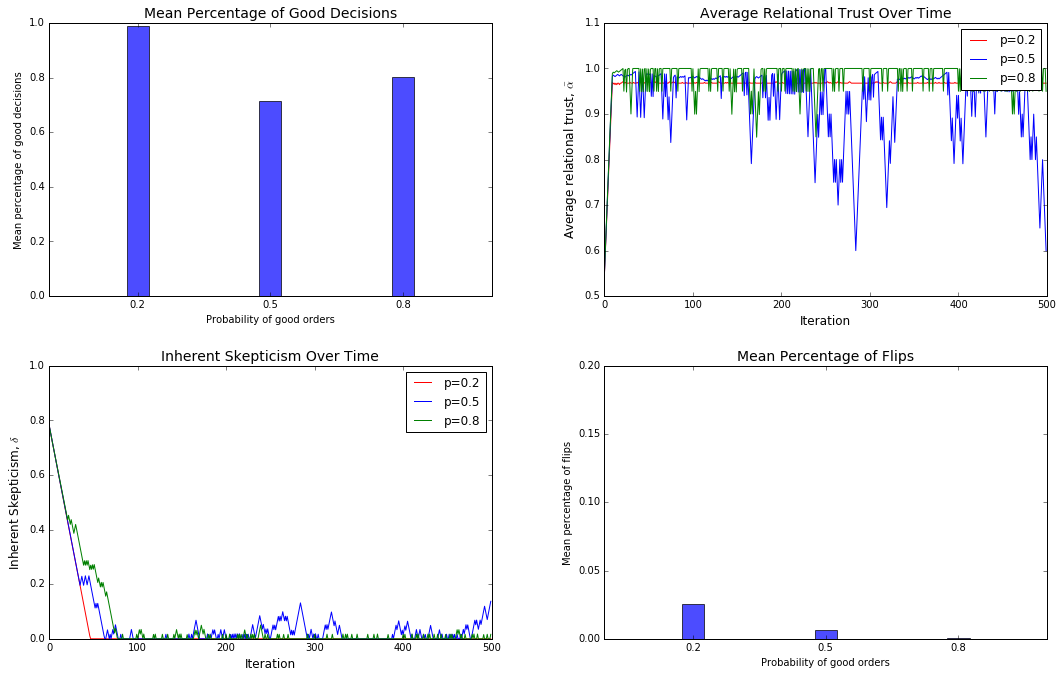

In [86]:
plot_four_figures(start_up, filename = "high_delta_high_info")

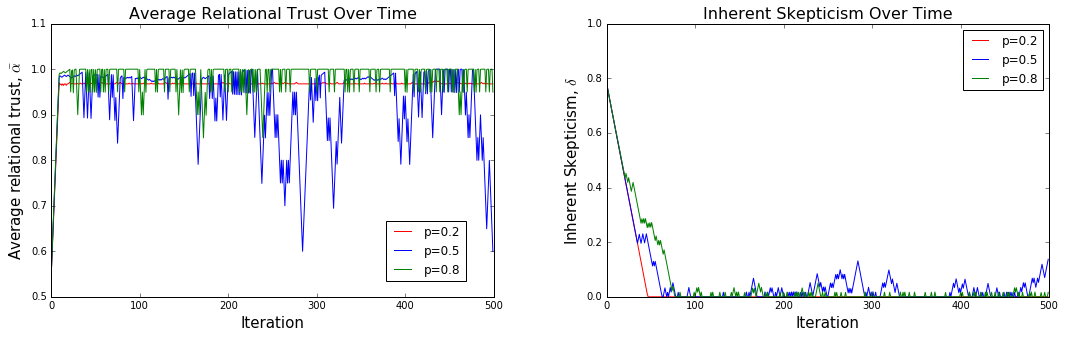

In [87]:
plot_two_figures(start_up, filename = "high_delta_high_info")

In [72]:
efficient_use_of_info = dict()
for p_good_order in [0.2,0.5,0.8]:
    plot_data = create_plots(iteration_count = 500, alpha = 0.5, delta = 0.2, info = 0.5, p_good_order = p_good_order, plot_network = False)
    efficient_use_of_info[p_good_order] = plot_data

iteration 0
-1
good
iteration 1
1
good
iteration 2
-1
good
iteration 3
-1
good
iteration 4
-1
good
iteration 5
-1
good
iteration 6
-1
good
iteration 7
1
good
iteration 8
-1
good
iteration 9
-1
good
iteration 10
-1
good
iteration 11
-1
good
iteration 12
1
good
iteration 13
-1
good
iteration 14
-1
good
iteration 15
-1
good
iteration 16
-1
good
iteration 17
1
good
iteration 18
-1
good
iteration 19
-1
good
iteration 20
-1
good
iteration 21
-1
good
iteration 22
-1
good
iteration 23
-1
good
iteration 24
-1
good
iteration 25
-1
good
iteration 26
-1
good
iteration 27
-1
good
iteration 28
1
good
iteration 29
-1
good
iteration 30
-1
good
iteration 31
-1
good
iteration 32
-1
good
iteration 33
1
good
iteration 34
-1
good
iteration 35
-1
good
iteration 36
-1
good
iteration 37
-1
good
iteration 38
1
good
iteration 39
-1
good
iteration 40
-1
good
iteration 41
-1
good
iteration 42
-1
good
iteration 43
-1
good
iteration 44
-1
good
iteration 45
-1
good
iteration 46
1
good
iteration 47
-1
good
iteration 

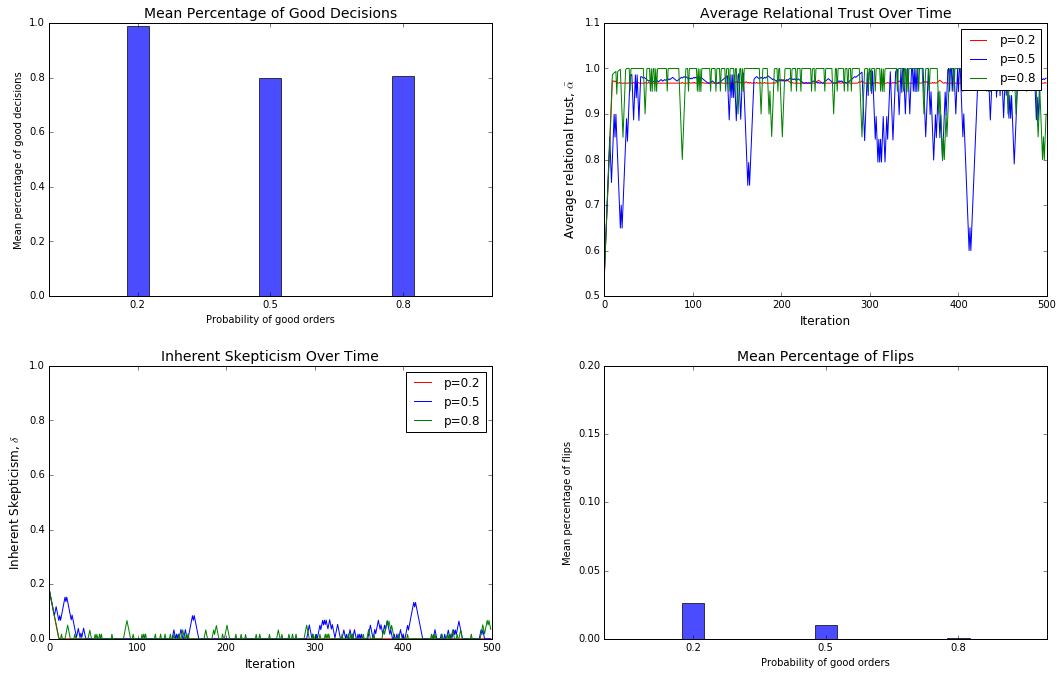

In [88]:
plot_four_figures(efficient_use_of_info, filename = "low_delta_high_info")

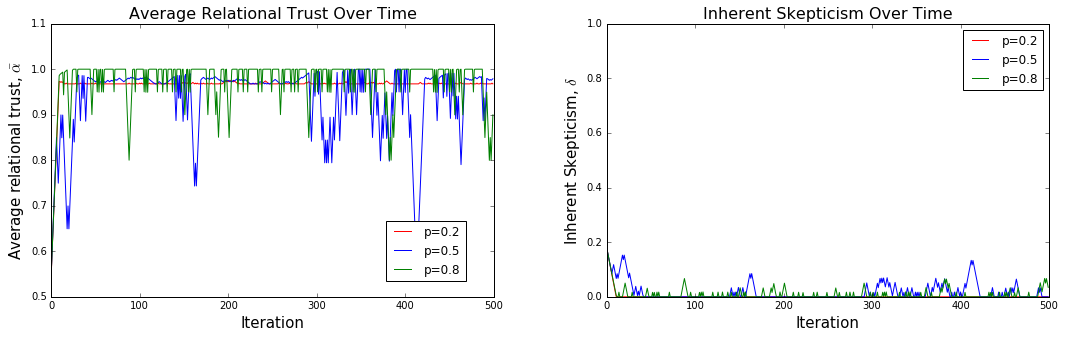

In [89]:
plot_two_figures(efficient_use_of_info, filename = "low_delta_high_info")

In [74]:
inefficient_use_of_info = dict()
for p_good_order in [0.2,0.5,0.8]:
    plot_data = create_plots(iteration_count = 500, alpha = 0.5, delta = 0.8, info = 0.1, p_good_order = p_good_order, plot_network = False)
    inefficient_use_of_info[p_good_order] = plot_data

iteration 0
-1
good
iteration 1
-1
good
iteration 2
-1
good
iteration 3
-1
good
iteration 4
-1
good
iteration 5
-1
good
iteration 6
-1
good
iteration 7
1
bad
iteration 8
-1
good
iteration 9
-1
good
iteration 10
-1
good
iteration 11
-1
good
iteration 12
-1
good
iteration 13
-1
good
iteration 14
-1
good
iteration 15
-1
good
iteration 16
-1
good
iteration 17
1
bad
iteration 18
-1
good
iteration 19
-1
good
iteration 20
-1
good
iteration 21
-1
good
iteration 22
-1
good
iteration 23
-1
good
iteration 24
-1
good
iteration 25
1
bad
iteration 26
-1
good
iteration 27
-1
good
iteration 28
-1
good
iteration 29
-1
good
iteration 30
-1
good
iteration 31
1
bad
iteration 32
-1
good
iteration 33
1
bad
iteration 34
-1
good
iteration 35
-1
good
iteration 36
-1
good
iteration 37
-1
good
iteration 38
1
bad
iteration 39
-1
good
iteration 40
1
bad
iteration 41
1
bad
iteration 42
-1
good
iteration 43
-1
good
iteration 44
1
bad
iteration 45
-1
good
iteration 46
-1
good
iteration 47
-1
good
iteration 48
-1
good

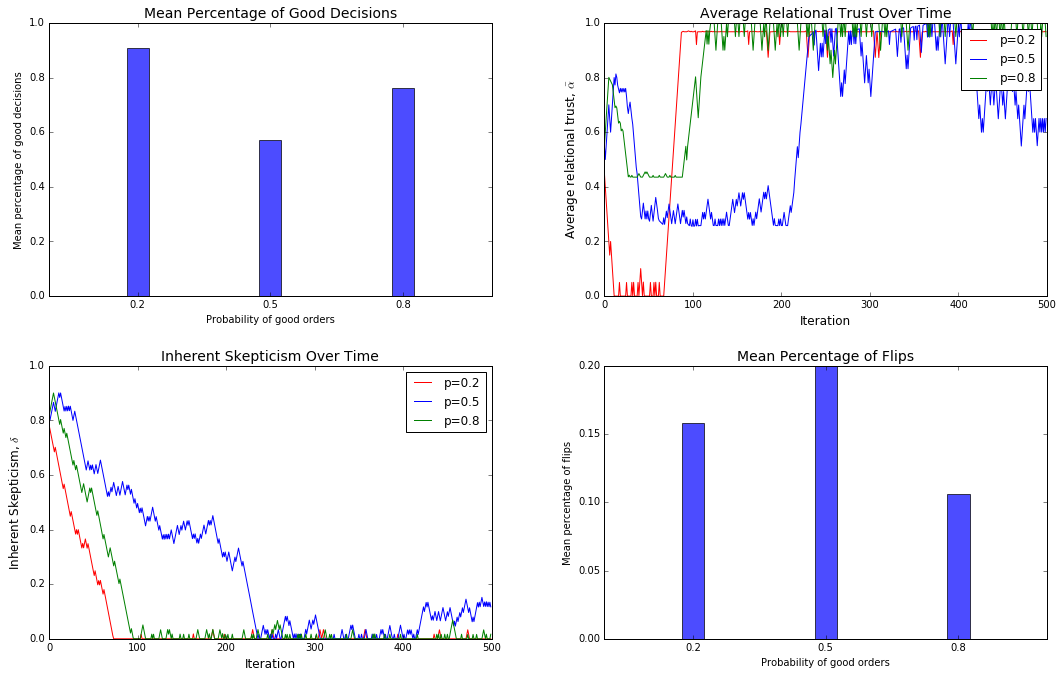

In [90]:
plot_four_figures(inefficient_use_of_info, filename = "high_delta_low_info")

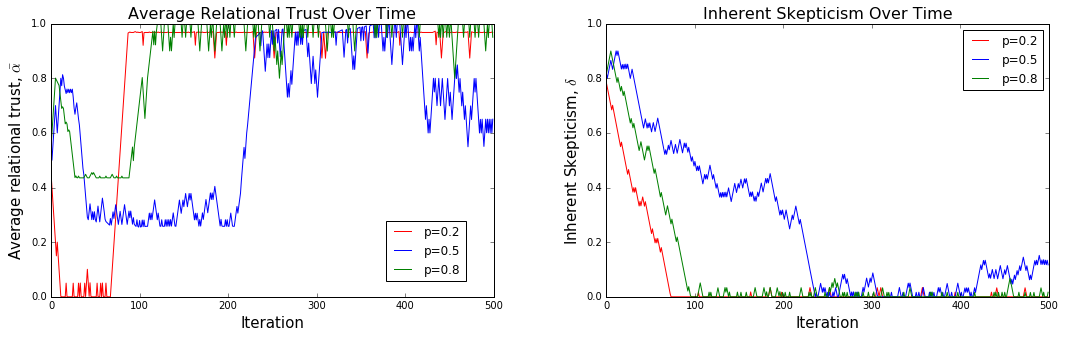

In [91]:
plot_two_figures(inefficient_use_of_info, filename = "high_delta_low_info")

In [75]:
reputed_org_blind_followers = dict()
for p_good_order in [0.2,0.5,0.8]:
    plot_data = create_plots(iteration_count = 500, alpha = 0.5, delta = 0.2, info = 0.1, p_good_order = p_good_order, plot_network = False)
    reputed_org_blind_followers[p_good_order] = plot_data

iteration 0
-1
bad
iteration 1
-1
bad
iteration 2
1
good
iteration 3
-1
bad
iteration 4
-1
bad
iteration 5
1
good
iteration 6
-1
bad
iteration 7
-1
good
iteration 8
-1
good
iteration 9
1
good
iteration 10
-1
good
iteration 11
-1
good
iteration 12
-1
good
iteration 13
-1
good
iteration 14
-1
good
iteration 15
-1
good
iteration 16
-1
good
iteration 17
-1
good
iteration 18
-1
good
iteration 19
-1
good
iteration 20
-1
good
iteration 21
-1
good
iteration 22
1
good
iteration 23
-1
good
iteration 24
-1
good
iteration 25
-1
good
iteration 26
-1
good
iteration 27
1
good
iteration 28
-1
good
iteration 29
-1
good
iteration 30
-1
good
iteration 31
-1
good
iteration 32
-1
good
iteration 33
-1
good
iteration 34
-1
good
iteration 35
1
good
iteration 36
-1
good
iteration 37
-1
good
iteration 38
-1
good
iteration 39
-1
good
iteration 40
-1
good
iteration 41
-1
good
iteration 42
-1
good
iteration 43
-1
good
iteration 44
-1
good
iteration 45
1
good
iteration 46
-1
good
iteration 47
1
good
iteration 48
-1

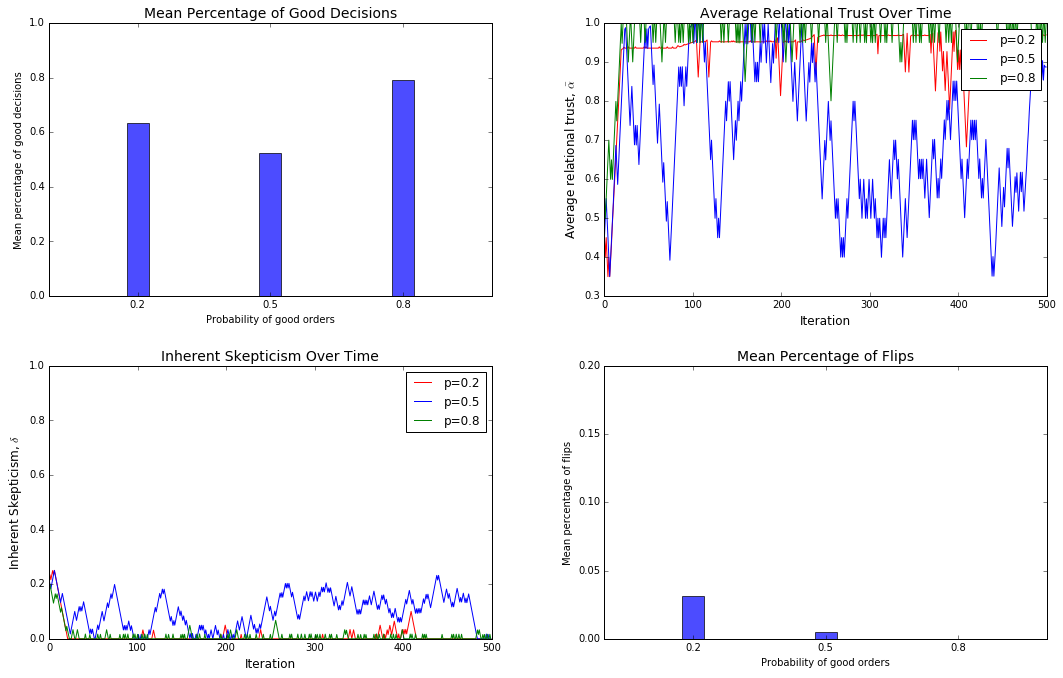

In [92]:
plot_four_figures(reputed_org_blind_followers, filename = "low_delta_low_info")

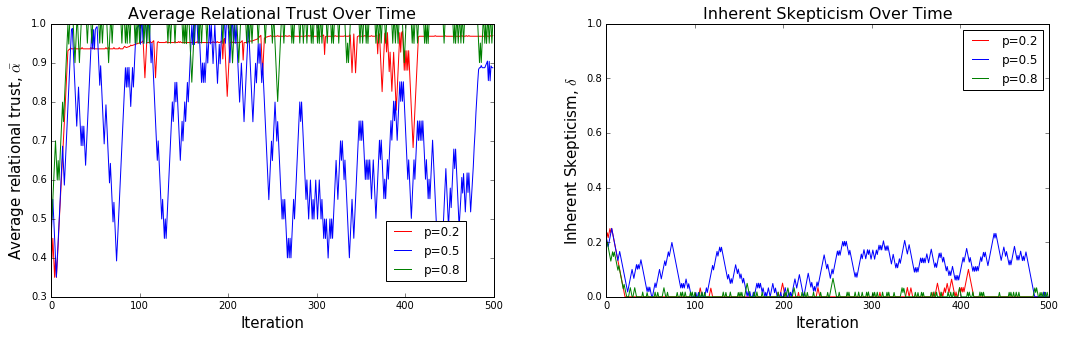

In [93]:
plot_two_figures(reputed_org_blind_followers, filename = "low_delta_low_info")

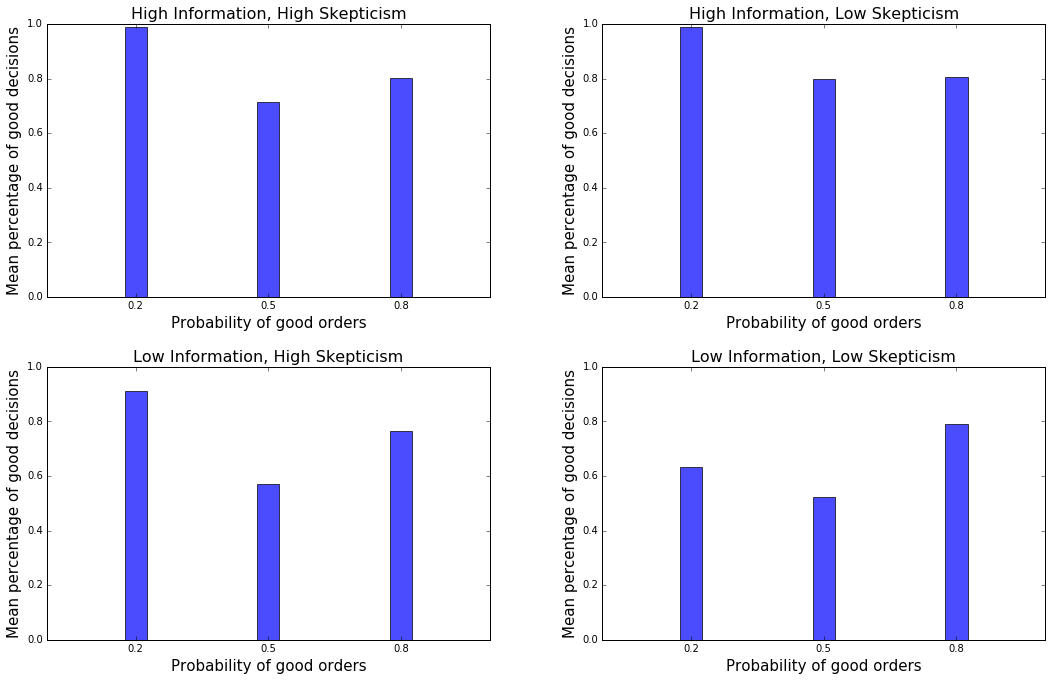

In [78]:

fig = plt.figure(figsize=(20,12))
gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
ax1 = fig.add_subplot(gs[0:44,0:44])
ax2 = fig.add_subplot(gs[0:44,55:99])
ax3 = fig.add_subplot(gs[55:99,0:44])
ax4 = fig.add_subplot(gs[55:99,55:99])


data = start_up
iterations = len(data.values()[0]['delta'])

#ax1 is for percentage of good order
data = start_up

mean = list()
error = list()

for p_good_order in sorted(data.keys()):
    percentage_good_orders = data[p_good_order]['good_orders']
    mean.append(np.mean(percentage_good_orders))
    error.append(np.std(percentage_good_orders))


ax1.bar(sorted(data.keys()), mean, width = 0.05, align = 'center', alpha = 0.7)
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xticks([0.2,0.5,0.8])
ax1.set_ylabel("Mean percentage of good decisions", fontsize = 15)
ax1.set_xlabel("Probability of good orders", fontsize = 15)
ax1.set_title(r"High Information, High Skepticism",fontsize=16)



#ax2 is for percentage of good order
data = efficient_use_of_info


mean = list()
error = list()

for p_good_order in sorted(data.keys()):
    percentage_good_orders = data[p_good_order]['good_orders']
    mean.append(np.mean(percentage_good_orders))
    error.append(np.std(percentage_good_orders))
    
ax2.bar(sorted(data.keys()), mean, width = 0.05, align = 'center', alpha = 0.7)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xticks([0.2,0.5,0.8])
ax2.set_ylabel("Mean percentage of good decisions", fontsize = 15)
ax2.set_xlabel("Probability of good orders", fontsize = 15)
ax2.set_title(r"High Information, Low Skepticism",fontsize=16)

#ax3 is for percentage of good order
data = inefficient_use_of_info

mean = list()
error = list()

for p_good_order in sorted(data.keys()):
    percentage_good_orders = data[p_good_order]['good_orders']
    mean.append(np.mean(percentage_good_orders))
    error.append(np.std(percentage_good_orders))


ax3.bar(sorted(data.keys()), mean, width = 0.05, align = 'center', alpha = 0.7)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_xticks([0.2,0.5,0.8])
ax3.set_ylabel("Mean percentage of good decisions", fontsize = 15)
ax3.set_xlabel("Probability of good orders", fontsize = 15)
ax3.set_title(r"Low Information, High Skepticism",fontsize=16)

#ax4 is for percentage of good order
data = reputed_org_blind_followers

mean = list()
error = list()

for p_good_order in sorted(data.keys()):
    percentage_good_orders = data[p_good_order]['good_orders']
    mean.append(np.mean(percentage_good_orders))
    error.append(np.std(percentage_good_orders))

ax4.bar(sorted(data.keys()), mean, width = 0.05, align = 'center', alpha = 0.7)
ax4.set_xlim(0,1)
ax4.set_ylim(0,1)
ax4.set_xticks([0.2,0.5,0.8])
ax4.set_ylabel("Mean percentage of good decisions", fontsize = 15)
ax4.set_xlabel("Probability of good orders", fontsize = 15)
ax4.set_title(r"Low Information, Low Skepticism",fontsize=16)

filename = "four_outcomes"

plt.savefig(filename+".eps", format='eps', dpi=1000)
plt.show()